<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/CNN_stock_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
#!pip install finta
SID = '1101.tw'
df = web.DataReader(SID,'yahoo',start="2000-01-01")
df = df.iloc[:,:5]

# 載入資料

In [2]:
print(df.shape)
df.head(3)

(4924, 5)


,High,Low,Open,Close,Volume
Date,,,,,
2000-01-04,18.226801,17.805401,17.805401,18.226801,9.716852e+10
2000-01-05,19.174999,17.858000,17.858000,18.700899,1.499255e+11
2000-01-06,18.753599,17.752701,18.542900,17.910700,7.448073e+10


In [3]:
df.tail(3)

,High,Low,Open,Close,Volume
Date,,,,,
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0


# Labeling(計算return)

In [0]:
#今天股價 = df['Close']
#昨天股價 = df['Close'].shift(1)
#df['return%'] = (今天股價/昨天股價-1)*100
#print(df['return%'].min(),df['return%'].max())
#sns.distplot(df['return%'].dropna())
#df.tail()

# Label triple_barrier

In [0]:
import numpy as np
import math
def triple_barrier(price, ub, lb, max_period):

    def end_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    
    r = np.array(range(max_period))
    
    def end_time(s):
        return np.append(r[(s / s[0] > ub) | (s / s[0] < lb)], max_period-1)[0]

    p = price.rolling(max_period).apply(end_price, raw=True).shift(-max_period+1)
    t = price.rolling(max_period).apply(end_time, raw=True).shift(-max_period+1)
    t = pd.Series([t.index[int(k+i)] if not math.isnan(k+i) else np.datetime64('NaT') 
                   for i, k in enumerate(t)], index=t.index).dropna()

    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = 1
    signal.loc[p < lb] = -1
    ret = pd.DataFrame({'triple_barrier_profit':p, 'triple_barrier_sell_time':t, 'triple_barrier_signal':signal})

    return ret

ret = triple_barrier(df.Close, 1.07, 0.97, 20)['triple_barrier_signal']
df = df.join(ret)

In [6]:
df.tail(20)

,High,Low,Open,Close,Volume,triple_barrier_signal
Date,,,,,,
2019-08-08,41.304199,40.930401,41.304199,41.023899,25584420.0,-1
2019-08-12,41.257500,41.023899,41.023899,41.070599,44490714.0,0
2019-08-13,37.849998,37.049999,37.849998,37.250000,47642885.0,0
2019-08-14,38.400002,37.549999,37.900002,38.299999,25945962.0,0
2019-08-15,38.200001,37.650002,37.950001,38.000000,15233101.0,0
2019-08-16,38.099998,37.799999,38.099998,37.950001,11940427.0,0
2019-08-19,38.400002,38.000000,38.150002,38.099998,12566435.0,0
2019-08-20,38.299999,38.099998,38.299999,38.150002,8093335.0,0
2019-08-21,38.200001,37.900002,38.150002,37.950001,11224764.0,0


(12.395027058062677, 30.324658114971992)

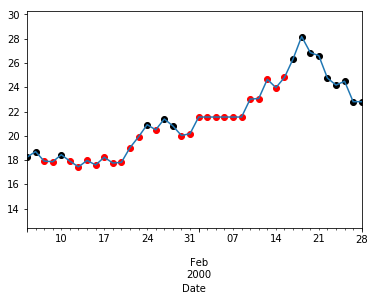

In [7]:
import matplotlib.pyplot as plt
buy = df[df['triple_barrier_signal']==1]['Close']
sell = df[df['triple_barrier_signal']==-1]['Close']
df['Close'][0:40].plot()#後20筆是前20筆的驗證
plt.scatter(buy.index,buy.values,color='red')
plt.scatter(sell.index,sell.values,color='black')
lb = df['Close'][0:40].mean() - 3*df['Close'][0:40].std()
ub = df['Close'][0:40].mean() + 3*df['Close'][0:40].std()
plt.ylim(lb,ub)

# 建立ohlcv

In [0]:
from finta import TA
ohlcv = df[['Open','High','Low','Close','Volume']]
ohlcv.columns = ['open','high','low','close','volume']

# 計算技術指標RSI

count    4923.000000
mean       50.966362
std        16.212361
min         5.387330
25%        39.625139
50%        50.960735
75%        62.543229
max       100.000000
Name: RSI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI
Date,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608


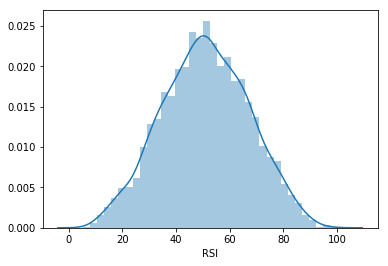

In [9]:
df['RSI'] = TA.RSI(ohlcv)
print(df['RSI'].describe())
sns.distplot(df['RSI'].dropna())
df.tail()

# 計算威廉指標

count    4911.000000
mean      -49.225964
std        30.539354
min      -100.000000
25%       -76.191299
50%       -48.550771
75%       -21.875748
max        -0.000000
Name: Williams %R, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R
Date,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390


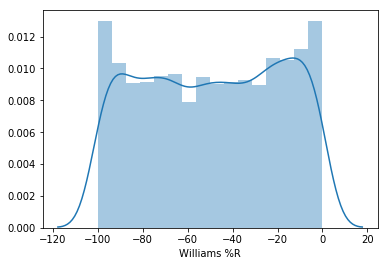

In [10]:
df['Williams %R'] = TA.WILLIAMS(ohlcv)
print(df['Williams %R'].describe())
sns.distplot(df['Williams %R'].dropna())
df.tail()

# SMA

count    4884.000000
mean       24.424357
std        10.885673
min         4.713275
25%        13.903199
50%        27.451118
75%        32.372582
max        46.202517
Name: SMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA
Date,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812


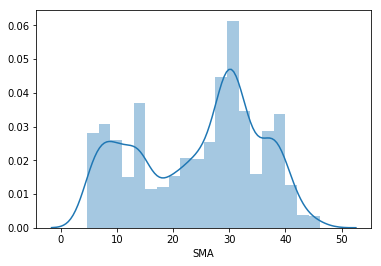

In [11]:
df['SMA'] = TA.SMA(ohlcv)
print(df['SMA'].describe())
sns.distplot(df['SMA'].dropna())
df.tail()

# EMA

count    4924.000000
mean       24.449213
std        10.937310
min         4.655782
25%        14.101755
50%        27.429411
75%        32.596660
max        47.458190
Name: EMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA
Date,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656


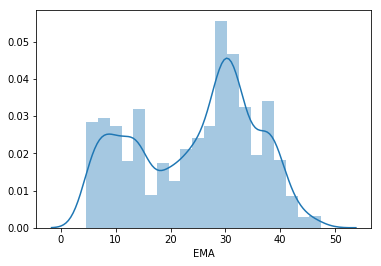

In [12]:
df['EMA'] = TA.EMA(ohlcv)
print(df['EMA'].describe())
sns.distplot(df['EMA'])
df.tail()

# WMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))


count    4916.000000
mean       24.453761
std        10.953464
min         4.639074
25%        14.050603
50%        27.432021
75%        32.491507
max        48.382182
Name: WMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA
Date,,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309,37.971112
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047,37.945556
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838,37.971111
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070,38.042223
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656,38.080000


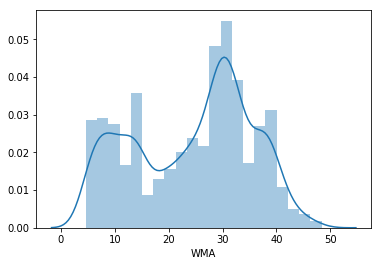

In [13]:
df['WMA'] = TA.WMA(ohlcv)
print(df['WMA'].describe())
sns.distplot(df['WMA'].dropna())
df.tail()

# HMA

/usr/local/lib/python3.6/dist-packages/finta/finta.py:263: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  wma = close_.apply(linear(weights))
/usr/local/lib/python3.6/dist-packages/finta/finta.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc['deltawma'] = 2 * wmaf - wmas


count    4921.000000
mean       24.461029
std        10.963963
min         4.605398
25%        14.047420
50%        27.401641
75%        32.492020
max        48.987559
Name: HMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA
Date,,,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309,37.971112,37.935000
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047,37.945556,38.140000
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838,37.971111,38.370000
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070,38.042223,38.395000
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656,38.080000,38.659999


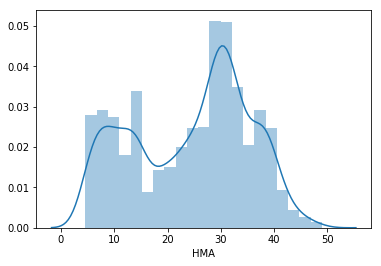

In [14]:
df['HMA'] = TA.HMA(ohlcv)
print(df['HMA'].describe())
sns.distplot(df['HMA'].dropna())
df.tail()

# TEMA

count    4924.000000
mean       24.465415
std        10.976168
min         4.580900
25%        14.056918
50%        27.316516
75%        32.524648
max        48.845573
Name: TEMA, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA
Date,,,,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309,37.971112,37.935000,38.151178
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047,37.945556,38.140000,38.291419
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838,37.971111,38.370000,38.427871
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070,38.042223,38.395000,38.778368
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656,38.080000,38.659999,39.407377


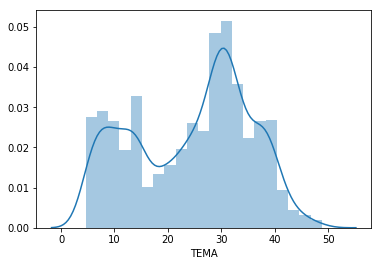

In [15]:
df['TEMA'] = TA.TEMA(ohlcv)
print(df['TEMA'].describe())
sns.distplot(df['TEMA'].dropna())
df.tail()

# CCI

count    4923.000000
mean        6.146937
std        87.779442
min      -248.770947
25%       -62.624005
50%         8.716654
75%        76.268994
max       256.327122
Name: CCI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI
Date,,,,,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309,37.971112,37.935000,38.151178,-27.051026
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047,37.945556,38.140000,38.291419,-17.181737
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838,37.971111,38.370000,38.427871,-9.174407
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070,38.042223,38.395000,38.778368,21.056878
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656,38.080000,38.659999,39.407377,79.794033


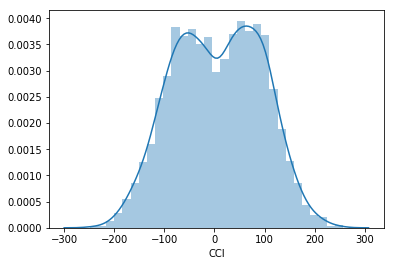

In [16]:
df['CCI'] = TA.CCI(ohlcv)
print(df['CCI'].describe())
sns.distplot(df['CCI'].dropna())
df.tail()

# CMO

count    4915.000000
mean        2.074831
std        41.560402
min      -100.000000
25%       -27.776932
50%         2.942777
75%        32.001650
max       100.000000
Name: CMO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO
Date,,,,,,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309,37.971112,37.935000,38.151178,-27.051026,6.666712
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047,37.945556,38.140000,38.291419,-17.181737,8.695508
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838,37.971111,38.370000,38.427871,-9.174407,22.727225
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070,38.042223,38.395000,38.778368,21.056878,43.396259
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656,38.080000,38.659999,39.407377,79.794033,52.380918


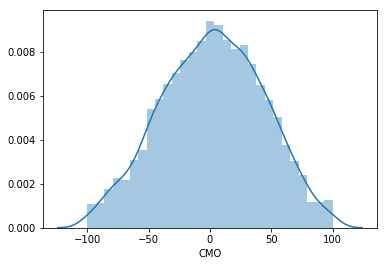

In [17]:
df['CMO'] = TA.CMO(ohlcv)
print(df['CMO'].describe())
sns.distplot(df['CMO'].dropna())
df.tail()

# MACD

count    4924.000000
mean       -0.000598
std         0.173549
min        -0.939441
25%        -0.079223
50%         0.003108
75%         0.089228
max         1.068114
Name: MACD, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD
Date,,,,,,,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309,37.971112,37.935000,38.151178,-27.051026,6.666712,0.067155
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047,37.945556,38.140000,38.291419,-17.181737,8.695508,0.105194
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838,37.971111,38.370000,38.427871,-9.174407,22.727225,0.137963
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070,38.042223,38.395000,38.778368,21.056878,43.396259,0.194114
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656,38.080000,38.659999,39.407377,79.794033,52.380918,0.280679


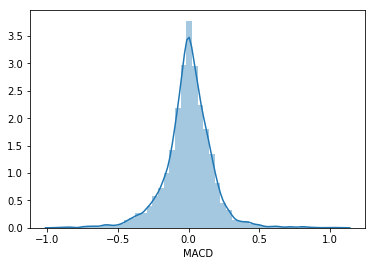

In [18]:
df['MACD'] = TA.MACD(ohlcv)['MACD'] - TA.MACD(ohlcv)['SIGNAL']
print(df['MACD'].describe())
sns.distplot(df['MACD'].dropna())
df.tail()

# PPO

count    4924.000000
mean       -0.001528
std         0.773727
min        -3.271988
25%        -0.382411
50%        -0.005235
75%         0.377056
max         4.481763
Name: PPO, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO
Date,,,,,,,,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309,37.971112,37.935000,38.151178,-27.051026,6.666712,0.067155,0.148518
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047,37.945556,38.140000,38.291419,-17.181737,8.695508,0.105194,0.247748
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838,37.971111,38.370000,38.427871,-9.174407,22.727225,0.137963,0.333963
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070,38.042223,38.395000,38.778368,21.056878,43.396259,0.194114,0.481426
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656,38.080000,38.659999,39.407377,79.794033,52.380918,0.280679,0.707580


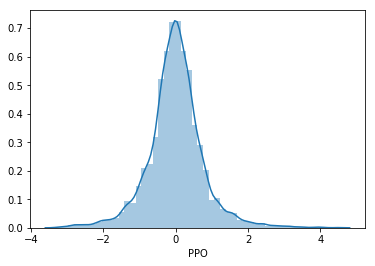

In [19]:
df['PPO'] = TA.PPO(ohlcv)['PPO'] - TA.PPO(ohlcv)['SIGNAL']
print(df['PPO'].describe())
sns.distplot(df['PPO'].dropna())
df.tail()

# ROC

count    4912.000000
mean        0.505667
std         8.062320
min       -37.298819
25%        -3.605771
50%         0.401055
75%         4.290795
max        59.222621
Name: ROC, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC
Date,,,,,,,,,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309,37.971112,37.935000,38.151178,-27.051026,6.666712,0.067155,0.148518,-0.130546
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047,37.945556,38.140000,38.291419,-17.181737,8.695508,0.105194,0.247748,0.921049
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838,37.971111,38.370000,38.427871,-9.174407,22.727225,0.137963,0.333963,1.317523
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070,38.042223,38.395000,38.778368,21.056878,43.396259,0.194114,0.481426,2.362209
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656,38.080000,38.659999,39.407377,79.794033,52.380918,0.280679,0.707580,4.456086


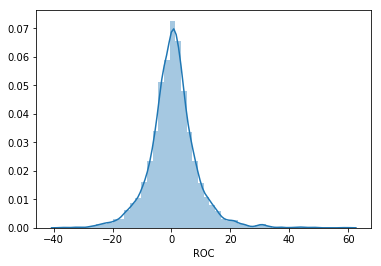

In [20]:
df['ROC'] = TA.ROC(ohlcv)
print(df['ROC'].describe())
sns.distplot(df['ROC'].dropna())
df.tail()

# CMFI

count    4.915000e+03
mean     1.773441e+12
std      3.711584e+11
min      3.920656e+09
25%      1.679980e+12
50%      1.999693e+12
75%      2.000144e+12
max      2.000755e+12
Name: CFI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI
Date,,,,,,,,,,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309,37.971112,37.935000,38.151178,-27.051026,6.666712,0.067155,0.148518,-0.130546,2.000377e+12
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047,37.945556,38.140000,38.291419,-17.181737,8.695508,0.105194,0.247748,0.921049,2.000376e+12
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838,37.971111,38.370000,38.427871,-9.174407,22.727225,0.137963,0.333963,1.317523,2.000376e+12
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070,38.042223,38.395000,38.778368,21.056878,43.396259,0.194114,0.481426,2.362209,2.000377e+12
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656,38.080000,38.659999,39.407377,79.794033,52.380918,0.280679,0.707580,4.456086,2.000382e+12


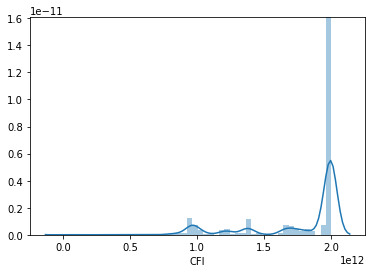

In [21]:
df['CFI'] = TA.CFI(ohlcv)
print(df['CFI'].describe())
sns.distplot(df['CFI'].dropna())
df.tail()

# DMI

/usr/local/lib/python3.6/dist-packages/finta/finta.py:792: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["up_move"] = ohlc["high"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:793: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ohlc["down_move"] = -ohlc["low"].diff()
/usr/local/lib/python3.6/dist-packages/finta/finta.py:809: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

count    4841.000000
mean        2.926466
std        21.847175
min      -106.418797
25%       -10.131990
50%         2.400520
75%        14.768660
max       111.272870
Name: DMI, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI
Date,,,,,,,,,,,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309,37.971112,37.935000,38.151178,-27.051026,6.666712,0.067155,0.148518,-0.130546,2.000377e+12,-2.843206
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047,37.945556,38.140000,38.291419,-17.181737,8.695508,0.105194,0.247748,0.921049,2.000376e+12,-2.464111
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838,37.971111,38.370000,38.427871,-9.174407,22.727225,0.137963,0.333963,1.317523,2.000376e+12,-0.863760
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070,38.042223,38.395000,38.778368,21.056878,43.396259,0.194114,0.481426,2.362209,2.000377e+12,11.999774
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656,38.080000,38.659999,39.407377,79.794033,52.380918,0.280679,0.707580,4.456086,2.000382e+12,38.222966


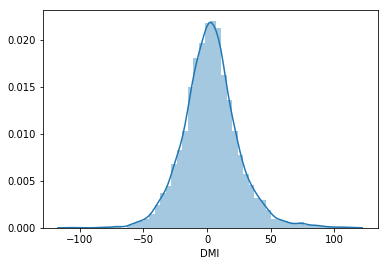

In [22]:
df['DMI'] = TA.DMI(ohlcv)['DI+'] - TA.DMI(ohlcv)['DI-']
print(df['DMI'].describe())
sns.distplot(df['DMI'].dropna())
df.tail()

# SAR

count    4924.000000
mean       24.419235
std        10.959764
min         4.563040
25%        14.067369
50%        27.127997
75%        32.305801
max        50.416199
Name: SAR, dtype: float64


,High,Low,Open,Close,Volume,triple_barrier_signal,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-02,38.450001,38.049999,38.450001,38.250000,16950621.0,0,45.631946,-14.285753,40.449951,38.176309,37.971112,37.935000,38.151178,-27.051026,6.666712,0.067155,0.148518,-0.130546,2.000377e+12,-2.843206,38.611149
2019-09-03,38.450001,38.250000,38.250000,38.349998,12035375.0,0,47.926160,-10.526548,40.339151,38.211047,37.945556,38.140000,38.291419,-17.181737,8.695508,0.105194,0.247748,0.921049,2.000376e+12,-2.464111,38.486257
2019-09-04,38.500000,38.250000,38.250000,38.450001,9142411.0,0,50.343993,-4.999924,40.225093,38.258838,37.971111,38.370000,38.427871,-9.174407,22.727225,0.137963,0.333963,1.317523,2.000376e+12,-0.863760,37.049999
2019-09-05,39.000000,38.500000,38.500000,39.000000,15438292.0,0,61.645234,-0.000000,40.123307,38.407070,38.042223,38.395000,38.778368,21.056878,43.396259,0.194114,0.481426,2.362209,2.000377e+12,11.999774,37.049999
2019-09-06,40.099998,39.049999,39.049999,39.849998,26871485.0,0,72.717608,-9.615390,40.046812,38.695656,38.080000,38.659999,39.407377,79.794033,52.380918,0.280679,0.707580,4.456086,2.000382e+12,38.222966,37.127999


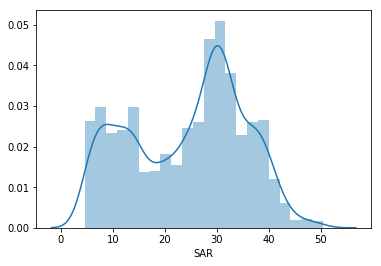

In [23]:
df['SAR'] = TA.SAR(ohlcv)
print(df['SAR'].describe())
sns.distplot(df['SAR'].dropna())
df.tail()

# columns選取

In [24]:
print(df.shape)
df = df.dropna(axis=0)#刪除有缺失的row,會缺失主要因為用時間rolling計算技術指標導致,正常的
features = df.columns[-15:].tolist() #取15個剛剛建立的技術指標當特徵
y_name = 'triple_barrier_signal' #當作labels
df = df[features+[y_name]]
print(df.shape)
df.tail()

(4924, 21)
(4841, 16)


,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-02,45.631946,-14.285753,40.449951,38.176309,37.971112,37.935000,38.151178,-27.051026,6.666712,0.067155,0.148518,-0.130546,2.000377e+12,-2.843206,38.611149,0
2019-09-03,47.926160,-10.526548,40.339151,38.211047,37.945556,38.140000,38.291419,-17.181737,8.695508,0.105194,0.247748,0.921049,2.000376e+12,-2.464111,38.486257,0
2019-09-04,50.343993,-4.999924,40.225093,38.258838,37.971111,38.370000,38.427871,-9.174407,22.727225,0.137963,0.333963,1.317523,2.000376e+12,-0.863760,37.049999,0
2019-09-05,61.645234,-0.000000,40.123307,38.407070,38.042223,38.395000,38.778368,21.056878,43.396259,0.194114,0.481426,2.362209,2.000377e+12,11.999774,37.049999,0
2019-09-06,72.717608,-9.615390,40.046812,38.695656,38.080000,38.659999,39.407377,79.794033,52.380918,0.280679,0.707580,4.456086,2.000382e+12,38.222966,37.127999,0


# 相關性分析

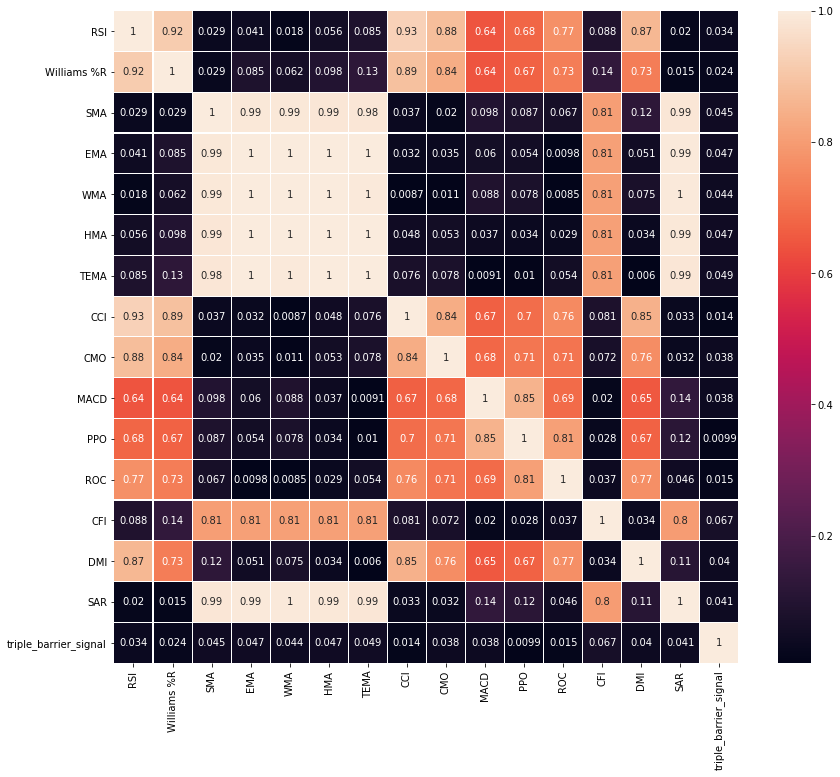

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
sns.heatmap(abs(df.corr()),annot=True,linewidths=0.1)

# features scaling

In [26]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_minmax = min_max_scaler.fit_transform(df)#縮放到0-1之間
df_minmax = pd.DataFrame(df_minmax,
                         index = df.index,
                         columns = df.columns)#轉回dataframe格式
df_minmax[y_name] = df[y_name]#y不用MinMaxScaler
df_minmax.tail()

,RSI,Williams %R,SMA,EMA,WMA,HMA,TEMA,CCI,CMO,MACD,PPO,ROC,CFI,DMI,SAR,triple_barrier_signal
Date,,,,,,,,,,,,,,,,
2019-09-02,0.447445,0.857142,0.861348,0.783146,0.761995,0.750968,0.758399,0.438964,0.533334,0.501404,0.441142,0.385078,0.999686,0.475790,0.742547,0
2019-09-03,0.472952,0.894735,0.858677,0.783957,0.761411,0.755587,0.761567,0.458503,0.543478,0.520352,0.453940,0.395973,0.999685,0.477532,0.739823,0
2019-09-04,0.499834,0.950001,0.855928,0.785074,0.761995,0.760770,0.764650,0.474356,0.613636,0.536675,0.465059,0.400080,0.999685,0.484883,0.708500,0
2019-09-05,0.625483,1.000000,0.853475,0.788537,0.763621,0.761333,0.772568,0.534209,0.716981,0.564644,0.484077,0.410904,0.999686,0.543974,0.708500,0
2019-09-06,0.748587,0.903846,0.851631,0.795279,0.764484,0.767304,0.786778,0.650497,0.761905,0.607764,0.513244,0.432597,0.999690,0.664434,0.710201,0


In [27]:
df = df_minmax
print('特徵縮放完成!')

特徵縮放完成!


# Xs ,ys prepare

In [28]:
from tqdm import tqdm
import numpy as np

#定義觀察天數,起始index(0),結束index(資料筆數-觀察天數)
days = 15
b_index = 0
f_index = len(df)-days

#特徵欄位
features = df.drop(y_name,axis=1).columns.tolist()

#待存放序列
Xs = []
ys = []
indexs = []

'''
若資料筆數100,days=15天,f_index=85,i只會跑到84,i+days=99,features只會跑到98天.
若資料筆數100,days=15天,f_index=85+1,i會跑到85,i+days=100,features會跑到99天.
'''
for i in tqdm(range(b_index ,f_index+1 ,1)):#每次i都會遞增1
  X = df.iloc[i:i+days,:][features] #ex:0...14(不含15)之features
  y = df.iloc[i+days-1:i+days,:][y_name]#ex:14,y_name
  X = np.array(X) # to np_array
  Xs.append(X) #加入一筆X
  ys.append(y) #加入一筆y
  indexs.append((df.iloc[[i]].index,
                 df.iloc[[i+days-1]].index)) #加入資料日期
#轉換成np_array
Xs = np.array(Xs)
ys = np.array(ys)
print('準備完成')

100%|██████████| 4827/4827 [00:09<00:00, 484.75it/s]


準備完成


# check

In [29]:
print('資料筆數:',len(Xs))
print('第一筆的index開始和結束:{}-{}'.format(indexs[0][0].date[0],indexs[0][1].date[0]))
print('最後一筆的index開始和結束:{}-{}'.format(indexs[-1][0].date[0],indexs[-1][1].date[0]))

資料筆數: 4827
第一筆的index開始和結束:2000-04-28-2000-05-18
最後一筆的index開始和結束:2019-08-16-2019-09-06


# Reshape X

(圖片數量,長,寬,1張)

In [30]:
print(Xs.shape)
Xs = Xs.reshape(-1,days,len(features),1)
print(Xs.shape)

(4827, 15, 15)
(4827, 15, 15, 1)


# One hot encoding of label

原始y代表漲幅

In [31]:
print(ys.shape)
print(ys[:5])

from keras.utils.np_utils import to_categorical
ys = to_categorical(ys, num_classes = 3)
print(ys.shape)
print(ys[:5])

(4827, 1)
[[-1]
 [-1]
 [-1]
 [-1]
 [-1]]


Using TensorFlow backend.


(4827, 3)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


# Visualization

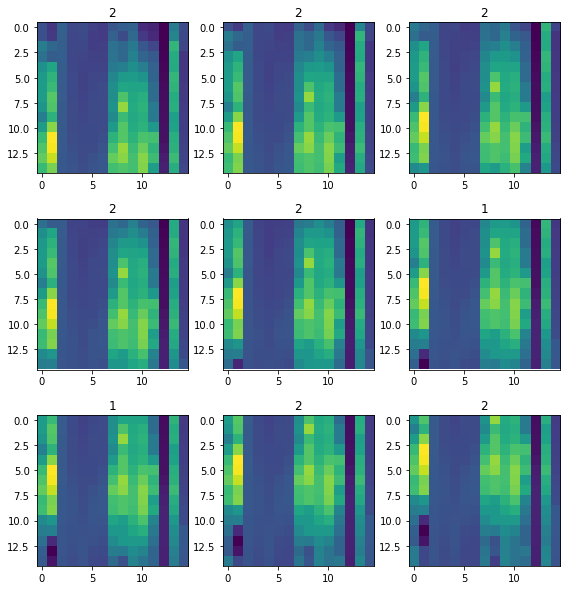

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
Xs_v = Xs.reshape(-1,Xs.shape[1],Xs.shape[2])
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace =0, hspace =0.3)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(Xs_v[i])
    plt.title(np.argmax(ys[i]))

# Split training and validation sets

In [33]:
X_test = Xs[-40:] #最後40天features當作test資料
X_train,y_train = Xs[:-40],ys[:-40] #其他當作訓練
print(X_train.shape,y_train.shape,X_test.shape)

(4787, 15, 15, 1) (4787, 3) (40, 15, 15, 1)


In [34]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X_train,
                                              y_train, 
                                              test_size=0.2,
                                              random_state=42,
                                              shuffle=True,#是否洗牌
                                              stratify=None #是否根據y欄位做分層取樣
                                             )
print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

(3829, 15, 15, 1) (3829, 3) (958, 15, 15, 1) (958, 3)


# 看一下樣本的label分布情況是否平均(待解決)

0:Hold,1:Buy,2:Sell

In [35]:
pd.Series([np.argmax(i) for i in ys]).value_counts()

2    2509
1    1271
0    1047
dtype: int64

In [36]:
pd.Series([np.argmax(i) for i in ytrain]).value_counts()

2    2008
1     992
0     829
dtype: int64

In [37]:
pd.Series([np.argmax(i) for i in yval]).value_counts()

2    482
1    279
0    197
dtype: int64

# CNN

In [0]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D
from keras.optimizers import Adam #做梯度下降的一種優化方法
from keras.callbacks import ReduceLROnPlateau , EarlyStopping #減少學習速率 on Plateau

In [39]:
model = Sequential()

nclasses = 3 

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(15,15,1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu',))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(nclasses, activation='softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 15, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    


In [40]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 優化器

In [0]:
#1
lr_reduction = ReduceLROnPlateau(monitor = 'val_acc', 
                                 factor=0.5, 
                                 patience = 3, 
                                 verbose = 1, 
                                 min_lr = 0.00001)

#2
es = EarlyStopping(monitor='val_acc',#驗證集acc
                   min_delta=0, 
                   patience=20,  
                   mode='max',
                   restore_best_weights=False)#恢復最佳權重

# fit

In [42]:
history = model.fit(xtrain,ytrain,
                    batch_size = 128,
                    epochs = 256,
                    validation_data=(xval,yval),
                    verbose=1,callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3829 samples, validate on 958 samples
Epoch 1/256
3829/3829 [==============================] - 3s 770us/step - loss: 1.0222 - acc: 0.5182 - val_loss: 1.0011 - val_acc: 0.5031
Epoch 2/256
3829/3829 [==============================] - 0s 52us/step - loss: 0.9966 - acc: 0.5244 - val_loss: 0.9990 - val_acc: 0.5031
Epoch 3/256
3829/3829 [==============================] - 0s 47us/step - loss: 0.9841 - acc: 0.5247 - val_loss: 0.9852 - val_acc: 0.5031
Epoch 4/256
3829/3829 [==============================] - 0s 45us/step - loss: 0.9740 - acc: 0.5252 - val_loss: 0.9810 - val_acc: 0.5031
Epoch 5/256
3829/3829 [==============================] - 0s 48us/step - loss: 0.9646 - acc: 0.5252 - val_loss: 0.9667 - val_acc: 0.4990
Epoch 6/256
3829/3829 [==============================] - 0s 46us/step - loss: 0.9572 - acc: 0.5289 - val_loss: 0.9657 - val_acc: 0.5031
Epoch 7/256
3829/3829 [===================

# 訓練過程評估

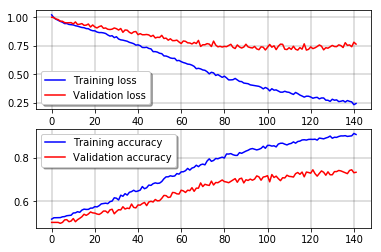

In [43]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

# 混淆矩陣

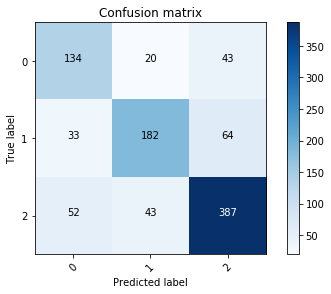

In [44]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#預測的y
ypred_onehot = model.predict(xval)
#轉換預測的y: [0 0 1 0 0 ...] --> 2
ypred = np.argmax(ypred_onehot,axis=1)
#轉換真實的y
ytrue = np.argmax(yval,axis=1)
#計算 confusion matrix
confusion_mtx = confusion_matrix(ytrue, ypred)
#畫出 confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

# 分類report

轉換預測結果

In [45]:
y_pred = model.predict(xval)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = to_categorical(y_pred, num_classes = 3)
print(y_pred[:5])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


真實y值

In [46]:
print(yval[:5])

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


# 分類報告

In [47]:
from sklearn.metrics import classification_report 
target_names = ['Hold','BUY','SELL']
print(classification_report(yval,y_pred,target_names=target_names))

              precision    recall  f1-score   support

        Hold       0.61      0.68      0.64       197
         BUY       0.74      0.65      0.69       279
        SELL       0.78      0.80      0.79       482

   micro avg       0.73      0.73      0.73       958
   macro avg       0.71      0.71      0.71       958
weighted avg       0.74      0.73      0.73       958
 samples avg       0.73      0.73      0.73       958



# plot error

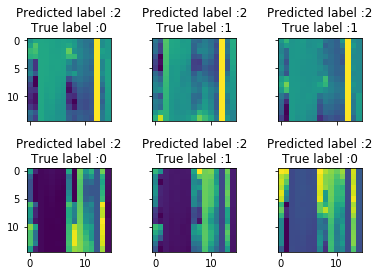

In [48]:
errors = (ypred - ytrue != 0)

ypred_er = ypred_onehot[errors]
ypred_classes_er = ypred[errors]
ytrue_er = ytrue[errors]
xval_er = xval[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    plt.subplots_adjust(wspace =0.5, hspace =0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((days,len(features))))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# 錯誤預測的概率
ypred_er_prob = np.max(ypred_er,axis=1)

# Predicted probabilities of the true values in the error set
true_prob_er = np.diagonal(np.take(ypred_er, ytrue_er, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_er = ypred_er_prob - true_prob_er

# Sorted list of the delta prob errors
sorted_delta_er = np.argsort(delta_pred_true_er)

# Top 6 errors. You can change the range to see other images
most_important_er = sorted_delta_er[-6:]

# Show the top 6 errors
display_errors(most_important_er, xval_er, ypred_classes_er, ytrue_er)

## 預測最後40筆

In [49]:
answer = model.predict(X_test)
answer = [ np.argmax(i) for i in answer]
print(len(answer))

40


# 0~20筆

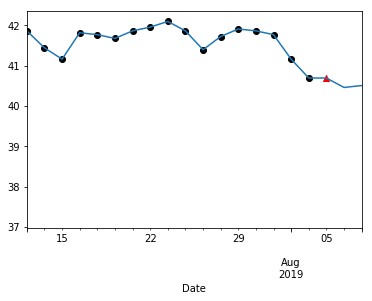

In [60]:
INDEX60 = df[-60:].index
C = web.DataReader(SID,'yahoo',start="2000-01-01")[['Close']]
C = C.loc[INDEX60,:]
C['SIGNAL'] = [np.nan for _ in range(20)] + answer #20個NAN+預測答案
buy = C[C['SIGNAL']==1]['Close']
sell = C[C['SIGNAL']==2]['Close']
C['Close'][20:40].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 20~40筆

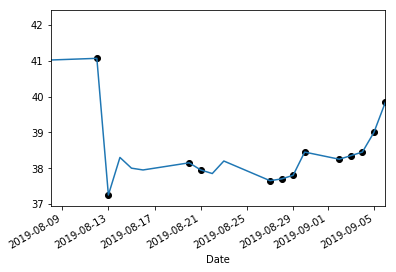

In [62]:
C['Close'][40:60].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 合併

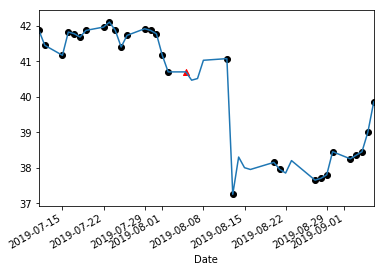

In [64]:
C['Close'][20:60].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')

# 平滑版本

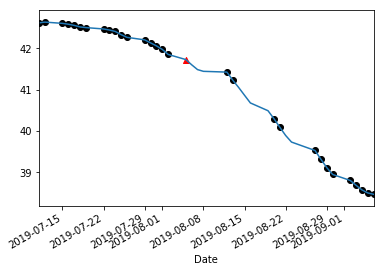

In [66]:
C_roll20 = pd.DataFrame(index=C.index)#空的dataframe index = 倒數60天股票日期
C_roll20['Close'] = C['Close'].rolling(20).mean()#收盤價做20天平滑
C_roll20['SIGNAL'] = C['SIGNAL']
buy = C_roll20[C_roll20['SIGNAL']==1]['Close']#買點
sell= C_roll20[C_roll20['SIGNAL']==2]['Close']#賣點
C_roll20['Close'][20:].plot()
plt.scatter(list(buy.index),list(buy.values),color='red',marker="^")
plt.scatter(list(sell.index),list(sell.values),color='black')